In [10]:
!pip install numpy==1.26

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [11]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmath 
import seaborn as sns
from simple_colors import *
sns.set()

In [12]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [13]:
import pandas as pd
import torch
import numpy as np

# Load the data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('../datasets/data/B00' + num + '.pkl')
    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']
    return charge, discharge, impedance

charge, discharge, impedance = split_data(cell_number=5)

# Convert pandas DataFrames to PyTorch tensors
def df_to_tensor(df):
    tensors = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            val = df[col].to_numpy(dtype=np.float32)  # Ensure numeric conversion
            tensors[col] = torch.tensor(val, dtype=torch.float32)
        else:
            print(f"Skipping non-numeric column: {col} (Type: {df[col].dtype})")
    return tensors

charge_tensors = df_to_tensor(charge)
discharge_tensors = df_to_tensor(discharge)
impedance_tensors = df_to_tensor(impedance)

print("Charge DataFrame columns and types:")
print(charge.dtypes)

print("Discharge DataFrame columns and types:")
print(discharge.dtypes)

print("Impedance DataFrame columns and types:")
print(impedance.dtypes)

# Example: Use 'ambient_temperature' and 'time' for training
if 'ambient_temperature' in charge_tensors and 'time' in charge_tensors:
    X = charge_tensors['ambient_temperature']
    y = charge_tensors['time']
    print("Data for training is prepared.")
else:
    print("Required columns are not present in charge_tensors.")
    if 'ambient_temperature' not in charge_tensors:
        print("Column 'ambient_temperature' is missing.")
    if 'time' not in charge_tensors:
        print("Column 'time' is missing.")


Skipping non-numeric column: type (Type: object)
Skipping non-numeric column: data (Type: object)
Skipping non-numeric column: type (Type: object)
Skipping non-numeric column: data (Type: object)
Skipping non-numeric column: type (Type: object)
Skipping non-numeric column: data (Type: object)
Charge DataFrame columns and types:
type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object
Discharge DataFrame columns and types:
type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object
Impedance DataFrame columns and types:
type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object
Data for training is prepared.


In [14]:
'''import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Improve data preprocessing
def preprocess_data(X, y, scaler_type='standard'):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaler type. Choose 'standard' or 'minmax'.")
    
    X_scaled = scaler.fit_transform(X)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 2. Modify RBM and DBN classes for better initialization and training
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))

    def sample_h(self, v):
        activation = torch.matmul(v, self.W) + self.h_bias
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, h):
        activation = torch.matmul(h, self.W.t()) + self.v_bias
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.v_bias)
        wx_b = torch.matmul(v, self.W) + self.h_bias
        hidden_term = torch.sum(torch.log(1 + torch.exp(wx_b)), dim=1)
        return -hidden_term - vbias_term

    def forward(self, v):
        return self.sample_h(v)[0]

class DBN(nn.Module):
    def __init__(self, visible_units, hidden_units_list):
        super(DBN, self).__init__()
        self.rbm_layers = nn.ModuleList()
        for i in range(len(hidden_units_list)):
            if i == 0:
                self.rbm_layers.append(RBM(visible_units, hidden_units_list[i]))
            else:
                self.rbm_layers.append(RBM(hidden_units_list[i-1], hidden_units_list[i]))

    def forward(self, v):
        for rbm in self.rbm_layers:
            v = rbm(v)
        return v

# 3. Implement improved training functions
def train_rbm(rbm, data, epochs=10, batch_size=32, lr=0.01):
    optimizer = optim.Adam(rbm.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_start in range(0, data.size(0), batch_size):
            batch = data[batch_start:batch_start+batch_size]
            v0 = batch
            h0, _ = rbm.sample_h(v0)
            v1, _ = rbm.sample_v(h0)
            h1, _ = rbm.sample_h(v1)
            
            loss = torch.mean(rbm.free_energy(v0) - rbm.free_energy(v1))
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data):.4f}')

def train_dbn(dbn, data, epochs=10, batch_size=32, lr=0.01):
    for i, rbm in enumerate(dbn.rbm_layers):
        print(f'Training RBM layer {i+1}')
        train_rbm(rbm, data, epochs, batch_size, lr)
        data = rbm(data).detach()  # Prepare data for the next layer

# 4. Define a more complex classifier
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.5):
        super(Classifier, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_size = hidden_size
        layers.append(nn.Linear(input_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# 5. Main training and evaluation function
def train_and_evaluate(X, y, hidden_layers, classifier_hidden_sizes, n_bins=10, epochs=100, batch_size=32, lr=0.01):
    # Preprocess data
    X_scaled, y = preprocess_data(X, y)
    
    # Bin the continuous labels
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbd.fit_transform(y.reshape(-1, 1))
    y_binned = torch.tensor(y_binned, dtype=torch.long).squeeze()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binned, test_size=0.2, random_state=42)
    
    # Initialize and train DBN
    input_size = X_train.size(1)
    dbn = DBN(input_size, hidden_layers)
    train_dbn(dbn, X_train, epochs=10, batch_size=batch_size, lr=lr)
    
    # Initialize and train classifier
    dbn_output_size = dbn.rbm_layers[-1].W.size(1)
    classifier = Classifier(dbn_output_size, classifier_hidden_sizes, n_bins)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            features = dbn(batch_X)
            outputs = classifier(features)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate the model
    dbn.eval()
    classifier.eval()
    with torch.no_grad():
        test_features = dbn(X_test)
        outputs = classifier(test_features)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
        print(f'Test Accuracy: {accuracy:.4f}')
        
        # Calculate RMSE
        y_pred_continuous = kbd.inverse_transform(predicted.numpy().reshape(-1, 1))
        y_true_continuous = kbd.inverse_transform(y_test.numpy().reshape(-1, 1))
        rmse = mean_squared_error(y_true_continuous, y_pred_continuous, squared=False)
        print(f'Root Mean Squared Error: {rmse:.4f}')
        
        # Classification report and confusion matrix
        print("\nClassification Report:")
        print(classification_report(y_test.numpy(), predicted.numpy()))
        
        cm = confusion_matrix(y_test.numpy(), predicted.numpy())
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
    return accuracy  # Add this line to return the accuracy score


# 6. Hyperparameter tuning
def hyperparameter_tuning(X, y):
    hidden_layers_options = [[128, 64, 32], [256, 128, 64], [512, 256, 128]]
    classifier_hidden_sizes_options = [[64, 32], [128, 64], [256, 128]]
    n_bins_options = [5, 10, 20]
    lr_options = [0.001, 0.01, 0.1]
    
    best_accuracy = 0
    best_params = {}
    
    for hidden_layers in hidden_layers_options:
        for classifier_hidden_sizes in classifier_hidden_sizes_options:
            for n_bins in n_bins_options:
                for lr in lr_options:
                    print(f"Training with parameters: hidden_layers={hidden_layers}, "
                          f"classifier_hidden_sizes={classifier_hidden_sizes}, "
                          f"n_bins={n_bins}, lr={lr}")
                    
                    accuracy = train_and_evaluate(X, y, hidden_layers, classifier_hidden_sizes, 
                                                  n_bins=n_bins, epochs=50, batch_size=32, lr=lr)
                    
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'hidden_layers': hidden_layers,
                            'classifier_hidden_sizes': classifier_hidden_sizes,
                            'n_bins': n_bins,
                            'lr': lr
                        }
    
    print("Best parameters:", best_params)
    print("Best accuracy:", best_accuracy)
    return best_params

# 7. Run the optimization
best_params = hyperparameter_tuning(X, y)

# 8. Final model training and evaluation
print("Training final model with best parameters:")
train_and_evaluate(X, y, best_params['hidden_layers'], best_params['classifier_hidden_sizes'], 
                   n_bins=best_params['n_bins'], epochs=10, batch_size=32, lr=best_params['lr']) '''

'import pandas as pd\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler, MinMaxScaler\nfrom sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# 1. Improve data preprocessing\ndef preprocess_data(X, y, scaler_type=\'standard\'):\n    if scaler_type == \'standard\':\n        scaler = StandardScaler()\n    elif scaler_type == \'minmax\':\n        scaler = MinMaxScaler()\n    else:\n        raise ValueError("Invalid scaler type. Choose \'standard\' or \'minmax\'.")\n    \n    X_scaled = scaler.fit_transform(X)\n    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)\n\n# 2. Modify RBM and DBN classes for better initialization and training\nclass RBM(nn.Module):\n    def __init__(self, n_visible, n_hidden):\n   

Pretraining RBM layer 1/2
RBM Layer 1, Epoch 1, Loss: 5.3552
RBM Layer 1, Epoch 2, Loss: 5.3525
RBM Layer 1, Epoch 3, Loss: 5.3504
RBM Layer 1, Epoch 4, Loss: 5.3496
RBM Layer 1, Epoch 5, Loss: 5.3460
RBM Layer 1, Epoch 6, Loss: 5.3467
RBM Layer 1, Epoch 7, Loss: 5.3417
RBM Layer 1, Epoch 8, Loss: 5.3398
RBM Layer 1, Epoch 9, Loss: 5.3396
RBM Layer 1, Epoch 10, Loss: 5.3402
Pretraining RBM layer 2/2
RBM Layer 2, Epoch 1, Loss: 0.0403
RBM Layer 2, Epoch 2, Loss: 0.0382
RBM Layer 2, Epoch 3, Loss: 0.0368
RBM Layer 2, Epoch 4, Loss: 0.0351
RBM Layer 2, Epoch 5, Loss: 0.0337
RBM Layer 2, Epoch 6, Loss: 0.0318
RBM Layer 2, Epoch 7, Loss: 0.0311
RBM Layer 2, Epoch 8, Loss: 0.0299
RBM Layer 2, Epoch 9, Loss: 0.0289
RBM Layer 2, Epoch 10, Loss: 0.0280
Finetuning Epoch 1, Loss: 0.7004
Finetuning Epoch 2, Loss: 0.6961
Finetuning Epoch 3, Loss: 0.6931
Finetuning Epoch 4, Loss: 0.6913
Finetuning Epoch 5, Loss: 0.6907
Finetuning Epoch 6, Loss: 0.6909
Finetuning Epoch 7, Loss: 0.6915
Finetuning Epoc

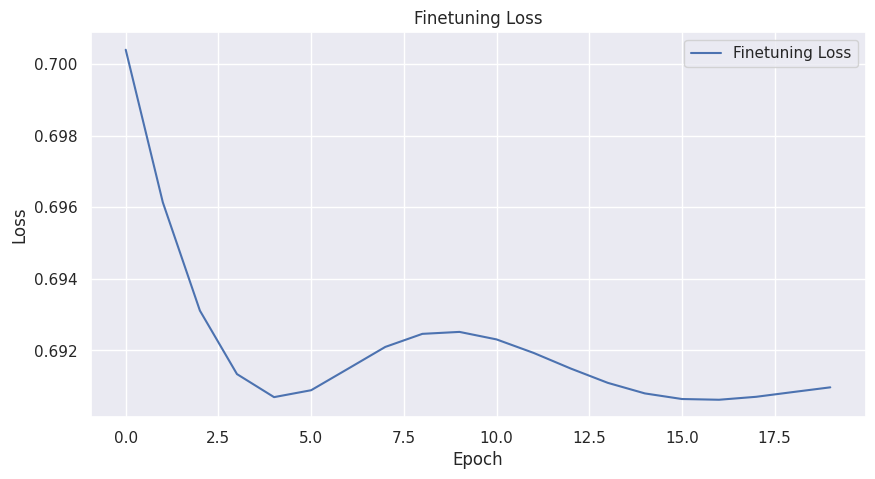

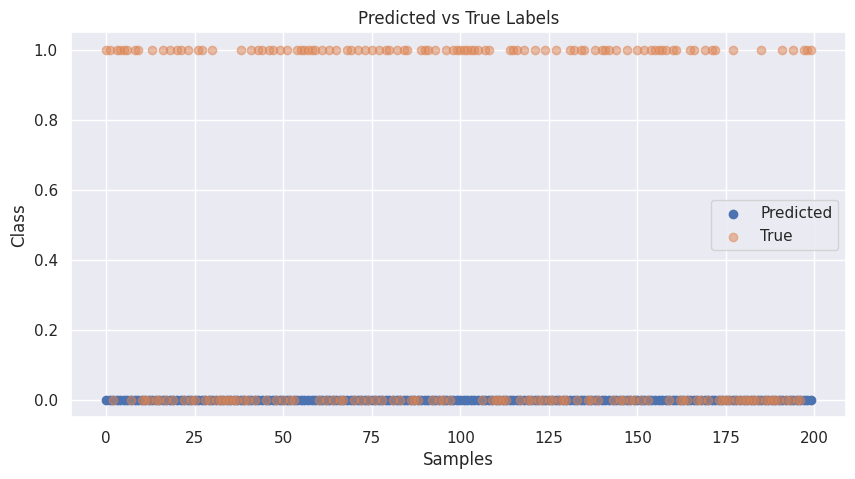

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the RBM class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def contrastive_divergence(self, v, lr):
        v0 = v
        h_prob, h_sample = self.sample_h(v0)
        v_prob, v_sample = self.sample_v(h_sample)
        h_prob_1, _ = self.sample_h(v_sample)

        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_1.t(), v_sample)

        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.v_bias.data += lr * torch.mean(v0 - v_sample, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob - h_prob_1, dim=0)

        loss = torch.mean(torch.sum((v0 - v_prob) ** 2, dim=1))
        return loss.item()

# Define the DBN class
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(n_visible if i == 0 else hidden_layers[i-1], h) for i, h in enumerate(hidden_layers)])
        self.classifier = nn.Linear(hidden_layers[-1], n_output)

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_h(x)
        return torch.softmax(self.classifier(x), dim=1)

    def pretrain(self, data, epochs=10, lr=0.01):
        data = data.float()  # Ensure data is float32
        for layer_num, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {layer_num + 1}/{len(self.rbms)}")
            layer_input = data
            if layer_num > 0:
                for prev_rbm in self.rbms[:layer_num]:
                    layer_input, _ = prev_rbm.sample_h(layer_input)
            for epoch in range(epochs):
                loss = rbm.contrastive_divergence(layer_input, lr)
                print(f"RBM Layer {layer_num + 1}, Epoch {epoch + 1}, Loss: {loss:.4f}")

# Example data preparation (replace with actual data loading)
# Replace these lines with actual data loading
X, y = torch.rand(1000, 64), torch.randint(0, 2, (1000,))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize DBN with two RBM layers
dbn = DBN(n_visible=64, hidden_layers=[128, 64], n_output=2)

# Pretrain RBM layers
dbn.pretrain(data=X_train, epochs=10, lr=0.01)

# Fine-tuning with backpropagation
optimizer = optim.Adam(dbn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
finetune_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = dbn(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    finetune_losses.append(loss.item())
    print(f"Finetuning Epoch {epoch + 1}, Loss: {loss:.4f}")

# Test the model
with torch.no_grad():
    y_pred = torch.argmax(dbn(X_test), dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

# Visualizing the results
plt.figure(figsize=(10, 5))
plt.plot(finetune_losses, label='Finetuning Loss')
plt.title('Finetuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_pred, label='Predicted')
plt.scatter(range(len(y_test)), y_test, label='True', alpha=0.5)
plt.title('Predicted vs True Labels')
plt.xlabel('Samples')
plt.ylabel('Class')
plt.legend()
plt.show()


/tmp/ipykernel_249592/3280366138.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Pretraining RBM layer 1/2
RBM Layer 1, Epoch 1, Loss: 1040.8587
RBM Layer 1, Epoch 2, Loss: 1035.2043
RBM Layer 1, Epoch 3, Loss: 1029.7487
RBM Layer 1, Epoch 4, Loss: 1024.0008
RBM Layer 1, Epoch 5, Loss: 1018.1787
RBM Layer 1, Epoch 6, Loss: 1012.1549
RBM Layer 1, Epoch 7, Loss: 1006.1618
RBM Layer 1, Epoch 8, Loss: 1000.2910
RBM Layer 1, Epoch 9, Loss: 994.5350
RBM Layer 1, Epoch 10, Loss: 988.9127
RBM Layer 1, Epoch 11, Loss: 983.3810
RBM Layer 1, Epoch 12, Loss: 978.2793
RBM Layer 1, Epoch 13, Loss: 973.2197
RBM Layer 1, Epoch 14, Loss: 968.4885
RBM Layer 1, Epoch 15, Loss: 963.5783
RBM Layer 1, Epoch 16, Loss: 959.0250
RBM Layer 1, Epoch 17, Loss: 954.4444
RBM Layer 1, Epoch 18, Loss: 950.4227
RBM Layer 1, Epoch 19, Loss: 946.3437
RBM Layer 1, Epoch 20, Loss: 942.6809
Pretraining RBM layer 2/2
RBM Layer 2, Epoch 1, Loss: 117.2848
RBM Layer 2, Epoch 2, Loss: 76.9858
RBM Layer 2, Epoch 3, Loss: 74.9475
RBM Layer 2, Epoch 4, Loss: 75.7454
RBM Layer 2, Epoch 5, Loss: 75.2179
RBM Laye

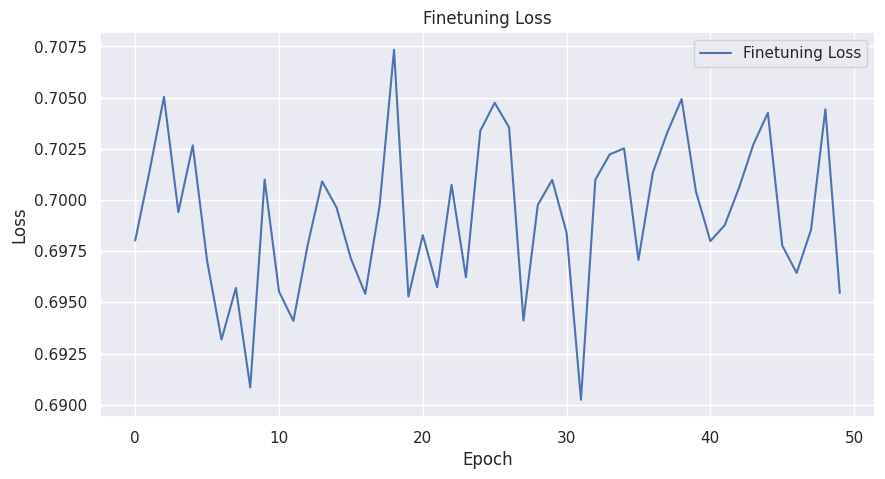

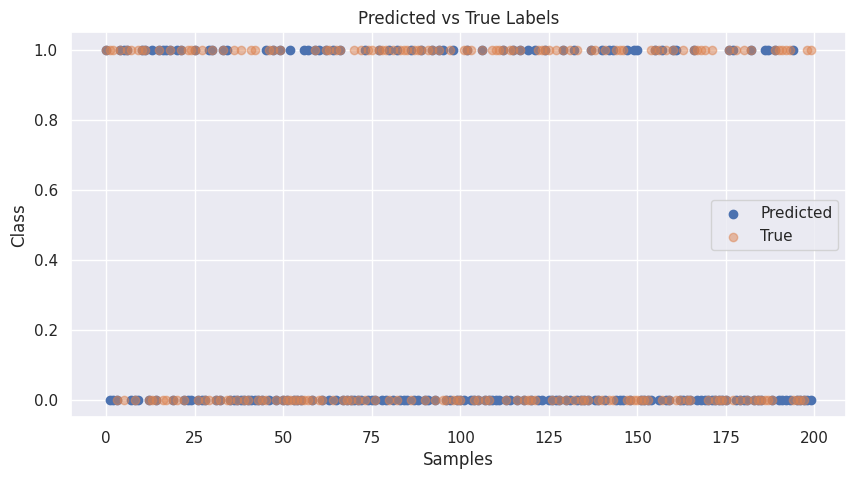

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the RBM class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, activation_fn='sigmoid'):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.activation_fn = activation_fn

    def activation(self, x):
        if self.activation_fn == 'relu':
            return F.relu(x)
        elif self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.01)
        return torch.sigmoid(x)  # Default to sigmoid

    def sample_h(self, v):
        h_prob = self.activation(F.linear(v, self.W, self.h_bias))
        h_prob = torch.sigmoid(h_prob)  # Ensure the output is between 0 and 1
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = self.activation(F.linear(h, self.W.t(), self.v_bias))
        v_prob = torch.sigmoid(v_prob)  # Ensure the output is between 0 and 1
        return v_prob, torch.bernoulli(v_prob)

    def contrastive_divergence(self, v, lr):
        v0 = v
        h_prob, h_sample = self.sample_h(v0)
        v_prob, v_sample = self.sample_v(h_sample)
        h_prob_1, _ = self.sample_h(v_sample)

        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_1.t(), v_sample)

        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.v_bias.data += lr * torch.mean(v0 - v_sample, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob - h_prob_1, dim=0)

        loss = torch.mean(torch.sum((v0 - v_prob) ** 2, dim=1))
        return loss.item()

# Define the DBN class with Dropout
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output, activation_fn='sigmoid', dropout_prob=0.5):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(n_visible if i == 0 else hidden_layers[i-1], h, activation_fn) for i, h in enumerate(hidden_layers)])
        self.classifier = nn.Linear(hidden_layers[-1], n_output)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_h(x)
            x = self.dropout(x)  # Apply dropout after each RBM layer
        return torch.softmax(self.classifier(x), dim=1)

    def pretrain(self, data, batch_size=64, epochs=10, lr=0.01):
        data = data.float()
        for layer_num, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {layer_num + 1}/{len(self.rbms)}")
            layer_input = data
            if layer_num > 0:
                for prev_rbm in self.rbms[:layer_num]:
                    layer_input, _ = prev_rbm.sample_h(layer_input)
            for epoch in range(epochs):
                epoch_loss = 0
                for i in range(0, data.size(0), batch_size):
                    batch = layer_input[i:i+batch_size]
                    loss = rbm.contrastive_divergence(batch, lr)
                    epoch_loss += loss
                print(f"RBM Layer {layer_num + 1}, Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

# Initialize DBN with two RBM layers
dbn = DBN(n_visible=64, hidden_layers=[128, 64], n_output=2, activation_fn='leaky_relu', dropout_prob=0.5)

# Pretrain RBM layers
dbn.pretrain(data=X_train, batch_size=64, epochs=20, lr=0.01)

# Fine-tuning with backpropagation
optimizer = optim.Adam(dbn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
finetune_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = dbn(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    nn.utils.clip_grad_norm_(dbn.parameters(), max_norm=5.0)  # Gradient clipping
    optimizer.step()
    scheduler.step()
    finetune_losses.append(loss.item())
    print(f"Finetuning Epoch {epoch + 1}, Loss: {loss:.4f}")

# Test the model
with torch.no_grad():
    y_pred = torch.argmax(dbn(X_test), dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

# Visualizing the results
plt.figure(figsize=(10, 5))
plt.plot(finetune_losses, label='Finetuning Loss')
plt.title('Finetuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_pred, label='Predicted')
plt.scatter(range(len(y_test)), y_test, label='True', alpha=0.5)
plt.title('Predicted vs True Labels')
plt.xlabel('Samples')
plt.ylabel('Class')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the RBM class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, activation_fn='sigmoid'):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.activation_fn = activation_fn

    def activation(self, x):
        if self.activation_fn == 'relu':
            return F.relu(x)
        elif self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.01)
        return torch.sigmoid(x)  # Default to sigmoid

    def sample_h(self, v):
        h_prob = self.activation(F.linear(v, self.W, self.h_bias))
        h_prob = torch.sigmoid(h_prob)  # Ensure the output is between 0 and 1
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = self.activation(F.linear(h, self.W.t(), self.v_bias))
        v_prob = torch.sigmoid(v_prob)  # Ensure the output is between 0 and 1
        return v_prob, torch.bernoulli(v_prob)

    def contrastive_divergence(self, v, lr):
        v0 = v
        h_prob, h_sample = self.sample_h(v0)
        v_prob, v_sample = self.sample_v(h_sample)
        h_prob_1, _ = self.sample_h(v_sample)

        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_1.t(), v_sample)

        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.v_bias.data += lr * torch.mean(v0 - v_sample, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob - h_prob_1, dim=0)

        loss = torch.mean(torch.sum((v0 - v_prob) ** 2, dim=1))
        return loss.item()

# Define the DBN class with Dropout
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output, activation_fn='sigmoid', dropout_prob=0.5):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(n_visible if i == 0 else hidden_layers[i-1], h, activation_fn) for i, h in enumerate(hidden_layers)])
        self.classifier = nn.Linear(hidden_layers[-1], n_output)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_h(x)
            x = self.dropout(x)  # Apply dropout after each RBM layer
        return torch.softmax(self.classifier(x), dim=1)

    def pretrain(self, data, batch_size=64, epochs=10, lr=0.01):
        data = data.float()
        for layer_num, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {layer_num + 1}/{len(self.rbms)}")
            layer_input = data
            if layer_num > 0:
                for prev_rbm in self.rbms[:layer_num]:
                    layer_input, _ = prev_rbm.sample_h(layer_input)
            for epoch in range(epochs):
                epoch_loss = 0
                for i in range(0, data.size(0), batch_size):
                    batch = layer_input[i:i+batch_size]
                    loss = rbm.contrastive_divergence(batch, lr)
                    epoch_loss += loss
                print(f"RBM Layer {layer_num + 1}, Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

# Initialize DBN with two RBM layers
dbn = DBN(n_visible=64, hidden_layers=[128, 64], n_output=2, activation_fn='leaky_relu', dropout_prob=0.5)

# Pretrain RBM layers
dbn.pretrain(data=X_train, batch_size=64, epochs=20, lr=0.01)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RobustRBM(nn.Module):
    def __init__(self, n_visible, n_hidden, activation_fn='leaky_relu'):
        super(RobustRBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.activation_fn = activation_fn

    def activation(self, x):
        if self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.1)
        return torch.sigmoid(x)

    def sample_h(self, v):
        h_prob = self.activation(F.linear(v, self.W, self.h_bias))
        h_prob = torch.clamp(h_prob, 0, 1)  # Ensure probabilities are in [0, 1]
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        v_prob = torch.clamp(v_prob, 0, 1)  # Ensure probabilities are in [0, 1]
        return v_prob, torch.bernoulli(v_prob)

    def free_energy(self, v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

    def contrastive_divergence(self, v_pos, k=1):
        h_pos, _ = self.sample_h(v_pos)
        v_neg = v_pos.clone()
        for _ in range(k):
            _, h_neg = self.sample_h(v_neg)
            v_neg, _ = self.sample_v(h_neg)
        return self.free_energy(v_pos) - self.free_energy(v_neg)

class RobustDBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output):
        super(RobustDBN, self).__init__()
        self.rbms = nn.ModuleList([RobustRBM(n_visible if i == 0 else hidden_layers[i-1], h) for i, h in enumerate(hidden_layers)])
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_layers[-1], 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_h(x)
        return self.fc_layers(x)

    def pretrain(self, data, batch_size=64, epochs=10, lr=0.01):
        for i, rbm in enumerate(self.rbms):
            optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)
            for epoch in range(epochs):
                epoch_loss = 0
                for batch in torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True):
                    optimizer.zero_grad()
                    loss = rbm.contrastive_divergence(batch)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                print(f"RBM {i+1}, Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
            with torch.no_grad():
                data = rbm.sample_h(data)[0].detach()

# Training function
def train_model(model, X, y, epochs=100, batch_size=64, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    dataset = torch.utils.data.TensorDataset(X, y)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return model

# Usage example
n_visible = X.shape[1]  # Number of input features
hidden_layers = [256, 128, 64]  # Define the hidden layer sizes
n_output = len(torch.unique(y))  # Number of classes

model = RobustDBN(n_visible, hidden_layers, n_output)
model.pretrain(X, epochs=20, lr=0.01)
trained_model = train_model(model, X, y)

# Evaluation
trained_model.eval()
with torch.no_grad():
    outputs = trained_model(X)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y).float().mean()
    print(f'Final Accuracy: {accuracy.item()*100:.2f}%')

RBM 1, Epoch 1, Loss: -1400.0560
RBM 1, Epoch 2, Loss: -2210.0004
RBM 1, Epoch 3, Loss: -2919.1007
RBM 1, Epoch 4, Loss: -3720.1825
RBM 1, Epoch 5, Loss: -4813.1066
RBM 1, Epoch 6, Loss: -5923.9378
RBM 1, Epoch 7, Loss: -7095.3563
RBM 1, Epoch 8, Loss: -8413.2361
RBM 1, Epoch 9, Loss: -9739.9875
RBM 1, Epoch 10, Loss: -10969.5893
RBM 1, Epoch 11, Loss: -12346.4258
RBM 1, Epoch 12, Loss: -13603.6307
RBM 1, Epoch 13, Loss: -15103.0619
RBM 1, Epoch 14, Loss: -16342.8989
RBM 1, Epoch 15, Loss: -17678.4068
RBM 1, Epoch 16, Loss: -19072.6380
RBM 1, Epoch 17, Loss: -20465.3754
RBM 1, Epoch 18, Loss: -21848.9656
RBM 1, Epoch 19, Loss: -23512.2999
RBM 1, Epoch 20, Loss: -24695.1071
RBM 2, Epoch 1, Loss: -582.2008
RBM 2, Epoch 2, Loss: -759.7027
RBM 2, Epoch 3, Loss: -757.9046
RBM 2, Epoch 4, Loss: -753.6512
RBM 2, Epoch 5, Loss: -724.2330
RBM 2, Epoch 6, Loss: -710.8627
RBM 2, Epoch 7, Loss: -703.2962
RBM 2, Epoch 8, Loss: -697.9218
RBM 2, Epoch 9, Loss: -713.2139
RBM 2, Epoch 10, Loss: -737.28

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

# Assume X and y are your input features and labels

# 1. Feature Selection (adjusted for fewer features)
def select_features(X, y, n_features=32):  # Reduced to half of max possible features
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = SelectFromModel(rf, max_features=n_features)
    selector.fit(X, y)
    return selector.transform(X), selector.get_support()

# 2. Advanced DBN with Residual Connections (adjusted for fewer features)
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class AdvancedDBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output):
        super(AdvancedDBN, self).__init__()
        layers = []
        for i, h in enumerate(hidden_layers):
            layers.append(nn.Linear(n_visible if i == 0 else hidden_layers[i-1], h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(ResidualBlock(h))
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_layers[-1], n_output)

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

# 3. Ensemble Model (unchanged)
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

# 4. Training function (unchanged)
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    def lr_lambda(epoch):
        if epoch < 10:
            return epoch / 10
        return 0.5 * (1 + np.cos((epoch - 10) / (epochs - 10) * np.pi))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_acc = accuracy_score(y_val.cpu(), predicted.cpu())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    return model

# Main process
# 1. Feature selection (using all features if less than 32)
n_features = min(32, X.shape[1])
X_selected, feature_mask = select_features(X.numpy(), y.numpy(), n_features=n_features)
X_selected = torch.tensor(X_selected, dtype=torch.float32)

# 2. Data splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# 3. Create and train multiple models (adjusted hidden layers)
n_models = 5
models = []
for _ in range(n_models):
    model = AdvancedDBN(X_train_scaled.shape[1], [64, 32, 16], len(torch.unique(y)))
    trained_model = train_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    models.append(trained_model)

# 4. Create and train ensemble model
ensemble = EnsembleModel(models)
ensemble = train_model(ensemble, X_train_scaled, y_train, X_test_scaled, y_test, epochs=50)

# 5. Final evaluation
ensemble.eval()
with torch.no_grad():
    test_output = ensemble(X_test_scaled)
    _, predicted = torch.max(test_output, 1)
    accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
    print(f'Final Ensemble Accuracy: {accuracy:.4f}')

# 6. XGBoost model for comparison
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_scaled.numpy(), y_train.numpy())
xgb_pred = xgb_model.predict(X_test_scaled.numpy())
xgb_accuracy = accuracy_score(y_test.numpy(), xgb_pred)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

# 7. Combine DBN Ensemble and XGBoost predictions
ensemble_pred_proba = torch.softmax(test_output, dim=1).cpu().numpy()
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled.numpy())
combined_pred_proba = 0.6 * ensemble_pred_proba + 0.4 * xgb_pred_proba
combined_pred = np.argmax(combined_pred_proba, axis=1)
combined_accuracy = accuracy_score(y_test.numpy(), combined_pred)
print(f'Combined Model Accuracy: {combined_accuracy:.4f}')

Epoch 1, Val Loss: 0.7608, Val Accuracy: 0.4906
Epoch 2, Val Loss: 0.7817, Val Accuracy: 0.5142
Epoch 3, Val Loss: 0.7590, Val Accuracy: 0.5094
Epoch 4, Val Loss: 0.7301, Val Accuracy: 0.5142
Epoch 5, Val Loss: 0.7144, Val Accuracy: 0.5047
Epoch 6, Val Loss: 0.7134, Val Accuracy: 0.5142
Epoch 7, Val Loss: 0.7164, Val Accuracy: 0.5047
Epoch 8, Val Loss: 0.7286, Val Accuracy: 0.5660
Epoch 9, Val Loss: 0.7538, Val Accuracy: 0.5425
Epoch 10, Val Loss: 0.7792, Val Accuracy: 0.5660
Epoch 11, Val Loss: 0.8332, Val Accuracy: 0.5425
Epoch 12, Val Loss: 0.9213, Val Accuracy: 0.5000
Epoch 13, Val Loss: 0.9017, Val Accuracy: 0.5472
Epoch 14, Val Loss: 0.9388, Val Accuracy: 0.5519
Epoch 15, Val Loss: 0.9929, Val Accuracy: 0.5377
Epoch 16, Val Loss: 1.0207, Val Accuracy: 0.5189
Epoch 17, Val Loss: 1.0494, Val Accuracy: 0.5330
Epoch 18, Val Loss: 1.1037, Val Accuracy: 0.5142
Epoch 19, Val Loss: 1.1014, Val Accuracy: 0.5802
Epoch 20, Val Loss: 1.0834, Val Accuracy: 0.5660
Epoch 21, Val Loss: 1.1899, V

In [31]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# import numpy as np

# # ... (RobustRBM and RobustDBN classes remain unchanged)

# # Modified training function for the DBN
# def train_model(model, X, y, epochs=100, batch_size=64, lr=0.001, val_split=0.1):
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)
    
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

#     train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         for batch_x, batch_y in train_loader:
#             optimizer.zero_grad()
#             output = model(batch_x)
#             loss = criterion(output, batch_y)
#             loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
#             train_loss += loss.item()

#         scheduler.step()

#         model.eval()
#         with torch.no_grad():
#             val_output = model(X_val)
#             val_loss = criterion(val_output, y_val)
#             _, predicted = torch.max(val_output.data, 1)
#             accuracy = (predicted == y_val).float().mean()

#         print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}')

#     return model

# class DBNXGBoostEnsemble(nn.Module):
#     def __init__(self, n_visible, hidden_layers, n_output):
#         super(DBNXGBoostEnsemble, self).__init__()
#         self.dbn = RobustDBN(n_visible, hidden_layers, n_output)
#         self.xgb = None

#     def forward(self, x):
#         dbn_features = self.dbn(x)
#         return dbn_features

#     def fit(self, X, y, dbn_epochs=100, dbn_batch_size=64, dbn_lr=0.001, xgb_params=None):
#         # Train DBN
#         self.dbn = train_model(self.dbn, X, y, epochs=dbn_epochs, batch_size=dbn_batch_size, lr=dbn_lr)

#         # Extract features from DBN
#         self.dbn.eval()
#         with torch.no_grad():
#             dbn_features = self.dbn(X).numpy()

#         # Train XGBoost
#         if xgb_params is None:
#             xgb_params = {
#                 'max_depth': 6,
#                 'learning_rate': 0.1,
#                 'n_estimators': 100,
#                 'objective': 'multi:softprob',
#                 'num_class': len(torch.unique(y)),
#                 'subsample': 0.8,
#                 'colsample_bytree': 0.8,
#                 'random_state': 42
#             }
#         self.xgb = XGBClassifier(**xgb_params)
#         self.xgb.fit(dbn_features, y.numpy())

#     def predict(self, X):
#         self.dbn.eval()
#         with torch.no_grad():
#             dbn_features = self.dbn(X).numpy()
#         return self.xgb.predict(dbn_features)

# # Modified training function for the ensemble
# def train_ensemble(X, y, n_visible, hidden_layers, n_output, test_size=0.2, random_state=42):
#     # Split the data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     # Create and train the ensemble
#     ensemble = DBNXGBoostEnsemble(n_visible, hidden_layers, n_output)
#     ensemble.fit(X_train, y_train)

#     # Evaluate
#     y_pred = ensemble.predict(X_test)
#     accuracy = accuracy_score(y_test.numpy(), y_pred)
#     print(f'Ensemble Accuracy: {accuracy*100:.2f}%')

#     return ensemble

# # Usage example
# n_visible = X.shape[1]  # Number of input features
# hidden_layers = [256, 128, 64]  # Define the hidden layer sizes
# n_output = len(torch.unique(y))  # Number of classes

# # Ensure X and y are torch tensors
# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.long)

# # Train the ensemble
# trained_ensemble = train_ensemble(X, y, n_visible, hidden_layers, n_output)

# # Final evaluation on the entire dataset
# y_pred_final = trained_ensemble.predict(X)
# final_accuracy = accuracy_score(y.numpy(), y_pred_final)
# print(f'Final Accuracy on entire dataset: {final_accuracy*100:.2f}%')

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def eval_svr(train, test, training=True):
    global svr
    if training:
        svr = SVR()
        svr.fit(train[0], train[1])
    
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    y_pred = svr.predict(test[0])
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(y_pred, test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

    # Plotting the predicted vs actual values
    plt.figure(figsize=(10, 5))
    plt.scatter(test[1], y_pred, alpha=0.5)
    plt.title('SVR: Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

def eval_mlp(train, test, training=True, layer_size=100, max_iter=100):
    global mlp
    if training:
        mlp = MLPRegressor(hidden_layer_sizes=(layer_size,), max_iter=max_iter, verbose=True)
        mlp.fit(train[0], train[1])
    
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    y_pred = mlp.predict(test[0])
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(y_pred, test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

    # Plotting loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(mlp.loss_curve_)
    plt.title('MLP: Loss Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

def eval_rf(train, test, training=True, n_estimators=100):
    global regressor
    if training:
        regressor = RandomForestRegressor(n_estimators=n_estimators)
        regressor.fit(train[0], train[1])
    
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    y_pred = regressor.predict(test[0])
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(y_pred, test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_xgb(train, test, training=True):
    global xgbr
    if training:
        xgbr = XGBRegressor()
        xgbr.fit(train[0], train[1])
    
    print(blue(f"Evaluating the XGBoost Regressor...", 'bold'))
    y_pred = xgbr.predict(test[0])
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_abr(train, test, training=True):
    global abr
    if training:
        abr = AdaBoostRegressor()
        abr.fit(train[0], train[1])
    
    print(blue(f"Evaluating the AdaBoost Regressor...", 'bold'))
    y_pred = abr.predict(test[0])
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_lgbmr(train, test, training=True):
    global lgbmr
    if training:
        lgbmr = LGBMRegressor()
        lgbmr.fit(train[0], train[1])
    
    print(blue(f"Evaluating the LightGBM Regressor...", 'bold'))
    y_pred = lgbmr.predict(test[0])
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_cbr(train, test, training=True):
    global cbr
    if training:
        cbr = CatBoostRegressor(verbosity=0)
        cbr.fit(train[0], train[1])
    
    print(blue(f"Evaluating the CatBoost Regressor...", 'bold'))
    y_pred = cbr.predict(test[0])
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
